<a href="https://colab.research.google.com/github/hormigo69/nlp-0-100/blob/main/LSTM_NLP_clasificador_novelas_espa%C3%B1ol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto usando LSTMs con TensorFlow 2.0

Vamos a crear una Red Neuronal Recurrente (BiLSTM) capaz de clasificar si una secuencia de una novela pertenece a Benito Pérez Galdós o Emilia Pardo Bazán.
 - Idea y preparación del dataset de [Javier de La Rosa](https://twitter.com/versae)

## Importamos las librerías requeridas

In [1]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import requests
print(tf.__version__)

2.5.0


## Descarga del dataset

Descargaremos 3 novelas por autor

In [2]:
URLS = [
    ("galdos", "http://www.gutenberg.org/cache/epub/52392/pg52392.txt"),  # Miau
    ("galdos", "http://www.gutenberg.org/cache/epub/15725/pg15725.txt"),  # Doña Perfecta
    ("galdos", "http://www.gutenberg.org/cache/epub/17013/pg17013.txt"),  # Fortunata y Jacinta
    ("bazan", "https://www.gutenberg.org/files/65632/65632-0.txt"),  # La prueba
    ("bazan", "https://www.gutenberg.org/files/58059/58059-0.txt"),  # La Madre Naturaleza
    ("bazan", "https://www.gutenberg.org/cache/epub/17491/pg17491.txt"),  # La Tribuna
]

galdos = ""
bazan = ""
for author, url in tqdm(URLS):
    work_text = requests.get(url).text
    start_mark = "START OF "
    end_mark = "END OF "
    work_text = work_text[work_text.index(start_mark):work_text.index(end_mark)]
    if author == "galdos":
        galdos += "\n" + work_text
    else:
        bazan += "\n" + work_text

100%|██████████| 6/6 [00:01<00:00,  4.55it/s]


Vamos a dividir las novelas en secuencias de una longitude de 250 palabras. Podemos probar con una longitud superir e inferior. Al fin y al cabo es un parámetro a tener en cuenta cuando se define una RNN

In [3]:
n = 250

galdos_splits = galdos.split()
galdos_chunks = [galdos_splits[i:i + n] for i in range(0, len(galdos_splits), n)]

bazan_splits = bazan.split()
bazan_chunks = [bazan_splits[i:i + n] for i in range(0, len(bazan_splits), n)]

Ahora construiremos una tabla (`DataFrame`) con los textos de cada extracto y una segunda columna indicando si pertenecen la obra de Galdós con un 1 o de Pardo Bazán con un 0.

In [4]:
galdos_len = len(galdos_chunks)
bazan_len = len(bazan_chunks)
galdos_len, bazan_len 

(2426, 868)

In [5]:
galdos_df = pd.DataFrame(
    [" ".join(chunk) for chunk in galdos_chunks],
    columns=["text"]
).assign(labels=1).sample(frac=1).reset_index(drop=True)
bazan_df = pd.DataFrame(
    [" ".join(chunk) for chunk in bazan_chunks],
    columns=["text"]
).assign(labels=0).sample(frac=1).reset_index(drop=True)

In [6]:
galdos_df

,text,labels
0,base. =fúnebre= funereal. =funesto= baleful. =...,1
1,"D. Basilio Andrés de la Caña, que lo menos era...",1
2,preguntó después. --No parece por ninguna part...,1
3,pensamiento. Resido en las estrellas. Pongan a...,1
4,que se presente. No se ven hombres así todos l...,1
...,...,...
2421,one who is left; remainder. =resto= _m_ remain...,1
2422,entre personas de vida poco regular. ¡Si suced...,1
2423,en que las recogidas se alzaban sobre las punt...,1
2424,"de que es hijo de las tres, y tendrá tres madr...",1


In [7]:
bazan_df

,text,labels
0,esto --murmuró entre sí--. Y si no la echo me ...,0
1,docena de gallinas Ã¡ la sombra de un emparrad...,0
2,cómo se las compondría para presentársele siem...,0
3,"un radical que aquel viejo apacible, semejante...",0
4,conoce mejor que nosotros lo que nos hace falt...,0
...,...,...
863,"amigotes! Eran bien intencionados, eso sÃ­; pe...",0
864,sin ser oído; personas de voz escasa exclamaba...,0
865,en el suelo; y mandando enhoramala sus filosof...,0
866,entonces! Y luego... _lo de ahora_... la calen...,0


## División de los datasets

In [8]:
train_df = pd.concat(
    [galdos_df[:int(galdos_len*.2)], bazan_df[:int(bazan_len*.2)]],
    ignore_index=True
).sample(frac=1).reset_index(drop=True)
train_df

,text,labels
0,hablarle y decirle algún amoroso atrevimiento....,1
1,y la aplastaría; para llevada en vilo entre va...,0
2,farmacéutico en tono muy misterioso: «¿Ha prep...,1
3,"sÃ­, muy planchada y muy rizadita; y cuando pa...",0
4,"disputaban, no se peleaban nunca; el muchacho ...",0
...,...,...
653,"«Chica, no trabajes tanto, que te vas a cansar...",1
654,las horas de trabajo en la Fábrica. A cada pit...,0
655,que sentía. Indudablemente su natural rudo y a...,1
656,perfectos. El otro sentimiento procedía del fo...,1


In [9]:
eval_df = pd.concat(
    [galdos_df[int(galdos_len*.8):], bazan_df[int(bazan_len*.8):]],
    ignore_index=True
).sample(frac=1).reset_index(drop=True)
eval_df

,text,labels
0,el pecho y en el vientre. Barbarita quiso pone...,1
1,Tendremos ministerio Palanca». ¡Pobre Emilio!....,1
2,versión dada al novio sobre el suceso del día....,1
3,"la colocación de su esposo, fué abandonado el ...",1
4,"la frente, Gabriel Pardo se paseaba indeciso, ...",0
...,...,...
655,"pedazo de pan solo, á todas las riquezas del m...",1
656,y me figuré que irías en los coches de delante...,1
657,concertar planes--declaró el teniente con forz...,0
658,"= pals, in cahoots. =complacencia= _f_ complac...",1


In [10]:
train_df['labels'].value_counts()

1    485
0    173
Name: labels, dtype: int64

In [11]:
eval_df['labels'].value_counts()

1    486
0    174
Name: labels, dtype: int64

## Definimos algunos parámetros de la red

 - vocab_size = cómo de largo queremos que sea nuestro vocabulario. Si es demasiado corto, el rendimiento de la red sería muy pobre pues habrían muchos tokens desconocidos. Si es demasiado grande, nuestra red tardará más en entrenar.

 - embedding_dim: Este parámetro nos dice cómo de grandes queremos que sean los vectores que representan cada palabra de nuestro vocabulario. Normalmente, cuanto más grandes sean, mayor 'calidad' en la representación de las mismas.

 - max_length: Debemos definir una longitud máxima de secuencia puesto que nuestra red espera que todas tenga la misma longitud. En nuestro caso, como partimos el dataset en secuencias de 250 palabras, usaremos ese valor.

 - trunc_type: si una secuencia es más larga de 250 palabras la cortamos por detrás (post).

- padding_type = nos dice que en caso de que la secuencia se más corta de 250 tokens en qué parte de ésta se añade los tokens de padding (post = al final).

- oov_tok = `<OOV>` da un valor a las palabras/tokens que estén fuera de esas 5000 como máximo que hemos definido para nuestro vocabulario.


In [12]:
vocab_size = 5000
embedding_dim = 64
max_length = 250
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [13]:
train_articles = train_df['text'].tolist()
train_labels = train_df['labels'].tolist()

validation_articles = eval_df['text'].tolist()
validation_labels = eval_df['labels'].tolist()

print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

658
658
660
660


## Creamos el Tokenizer

Le vamos a decir cuál es el número máximo de palabras, el token para palabras que no estén en el vocabulario y que las pase minúsculas para reducir el tamaño del mismo

In [14]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok, lower=True)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'a': 8,
 'de': 2,
 'el': 6,
 'en': 7,
 'la': 4,
 'no': 9,
 'que': 3,
 'se': 10,
 'y': 5}

No hemos filtrado las `STOPWORDS` pero se podría.

Tokenizamos nuestro dataset de entrenamiento una vez que ya tenemos nuestro vocabulario listo.

In [15]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[94, 1, 90, 1, 6, 1, 1, 62, 93, 5, 2008, 9, 1, 29, 286, 10, 245, 4484, 5, 10, 1, 95, 43, 4485, 554, 1, 8, 409, 1, 8, 4486, 7, 631, 1, 18, 174, 21, 257, 2, 603, 21, 3439, 5, 21, 3440, 69, 168, 21, 3440, 536, 10, 3441, 17, 9, 2384, 4487, 46, 1601, 8, 4, 4488, 34, 4489, 2, 1, 5, 2767, 3442, 2, 3, 65, 47, 283, 8, 13, 177, 20, 4490, 1, 1135, 4491, 3, 2035, 1136, 7, 2759, 40, 1, 17, 3443, 4492, 56, 1, 13, 535, 7, 4, 363, 868, 23, 3, 7, 16, 1, 1, 5, 1, 143, 34, 209, 4493, 70, 118, 119, 122, 272, 23, 93, 56, 10, 4, 473, 239, 135, 1, 1789, 67, 27, 6, 101, 10, 1, 54, 9, 2, 44, 30, 37, 836, 3, 9, 18, 1056, 1770, 173, 7, 4, 116, 5, 17, 257, 2, 555, 55, 8, 102, 3444, 9, 30, 1, 1, 500, 1464, 178, 2, 280, 26, 556, 41, 1137, 3, 7, 1, 5, 4494, 47, 375, 501, 171, 248, 677, 2, 1, 3442, 2, 3, 70, 118, 16, 47, 1, 44, 5, 119, 188, 3, 16, 1, 8, 4, 2036, 41, 13, 1, 674, 10, 1, 1, 8, 21, 24, 1, 2, 4495, 22, 1790, 35, 2, 97, 6, 2037, 1791, 141, 993, 47, 830, 20, 3445, 15, 2385, 5, 12, 1441, 7, 13, 251, 1792, 38

Aplicamos padding a nuestras secuencias de entrenamientoi para que todas tengan la misma longitud (para este dataset no es neceario porque las dividimos con la misma longitud, pero en otros casos suele ser útil).

In [16]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

250
250
250
250
253
250


In [18]:
print(train_padded[10])

[  94    1   90    1    6    1    1   62   93    5 2008    9    1   29
  286   10  245 4484    5   10    1   95   43 4485  554    1    8  409
    1    8 4486    7  631    1   18  174   21  257    2  603   21 3439
    5   21 3440   69  168   21 3440  536   10 3441   17    9 2384 4487
   46 1601    8    4 4488   34 4489    2    1    5 2767 3442    2    3
   65   47  283    8   13  177   20 4490    1 1135 4491    3 2035 1136
    7 2759   40    1   17 3443 4492   56    1   13  535    7    4  363
  868   23    3    7   16    1    1    5    1  143   34  209 4493   70
  118  119  122  272   23   93   56   10    4  473  239  135    1 1789
   67   27    6  101   10    1   54    9    2   44   30   37  836    3
    9   18 1056 1770  173    7    4  116    5   17  257    2  555   55
    8  102 3444    9   30    1    1  500 1464  178    2  280   26  556
   41 1137    3    7    1    5 4494   47  375  501  171  248  677    2
    1 3442    2    3   70  118   16   47    1   44    5  119  188    3
   16 

Hacemos lo propio con el dataset de validación

In [19]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

660
(660, 250)


Codificamos correctamente las `labels`

In [20]:
training_label_seq = np.array(train_labels, dtype=np.int8)
validation_label_seq = np.array(validation_labels, dtype=np.int8)
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

1
0
1
(658,)
1
1
1
(660,)


Veamos cómo somos capaces de decodificar una secuencia tokenizada a texto de nuevo gracias al tokenizer que creamos

In [22]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

está <OOV> aquí <OOV> el <OOV> <OOV> » fortunata y feliciana no <OOV> pero rubín se puso encarnado y se <OOV> mucho porque aplicar tales <OOV> a personas <OOV> a unirse en santo <OOV> le parecía una falta de respeto una grosería y una cochinada sí señor una cochinada mas se calló por no armar camorra ni quitar a la reunión sus tonos de <OOV> y formalidad acordose de que nada había dicho a su amigo del casorio <OOV> siendo evidente que olmedo habló en términos tan <OOV> por ignorancia determinó pues <OOV> su pensamiento en la primera ocasión para que en lo <OOV> <OOV> y <OOV> mejor sus palabras viii aquella noche fue también mala para fortunata pues se la pasó casi toda <OOV> discurriendo sobre si el otro se <OOV> o no de ella era muy particular que no le hubiese encontrado nunca en la calle y por falta de mirar bien a todos lados no era <OOV> <OOV> malo estaría fuera de madrid más adelante cuando supo que en <OOV> y marzo había estado juanito santa cruz enfermo de <OOV> acordose de que

## Construimos nuestra red neuronal

- Utilizaremos la `Sequential` API de Keras
- Creamos una primera capa de `Embedding`que tiene por tamaño `vocab_size`x `embedding_dim`
- Despues añadimos nuestra capa de recurrencia. En este caso será una `LSTM` bidireccional (aprende de izquerida a derecha y de derecha a izquierda)
- Conectamos la salida de esa capa a una capa `Dense`.
- Por último, conectamos todo a una capa `Dense`con función de activación `sigmoid`ya que nuestro problema de clasificación es binario.

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 394,369
Trainable params: 394,369
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Entrenamos nuestro modelo

In [25]:
num_epochs = 4
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/4
21/21 - 12s - loss: 0.6326 - accuracy: 0.7264 - val_loss: 0.5768 - val_accuracy: 0.7364
Epoch 2/4
21/21 - 7s - loss: 0.5470 - accuracy: 0.7371 - val_loss: 0.5319 - val_accuracy: 0.7364
Epoch 3/4
21/21 - 7s - loss: 0.3793 - accuracy: 0.8116 - val_loss: 0.4210 - val_accuracy: 0.7106
Epoch 4/4
21/21 - 7s - loss: 0.1849 - accuracy: 0.9453 - val_loss: 0.3543 - val_accuracy: 0.8803


## Visualizamos los resultados

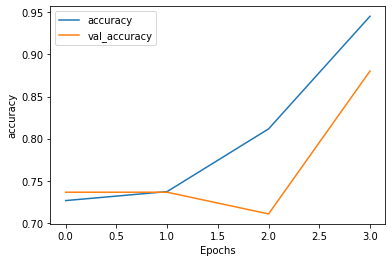

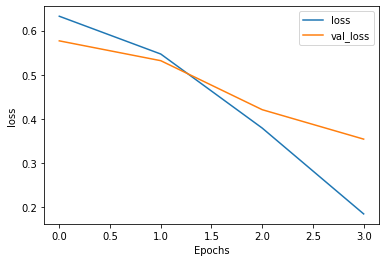

In [26]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Probemos nuestro modelo

In [41]:
validation_articles[50], validation_label_seq[50]

('y soldaduchos... Debiera trabar conversación, al menos para dar tiempo á que desfile Mendizábal... ¡Dios mío, líbrame de esa fiera ultramontana y facciosa!... Nada, que me gustan las niñas; sobre todo aquella que tiene el moño alto y el mantón colorado... También ella me mira, y... Ojo, Ramón, que estas aventuras son peligrosas. Modérate, y para hacer más tiempo, toma una copita más. Paisano, otra...» La partida salió, y Villaamil, calculando con rápida inspiración, se dijo: «Me meto entre ellos, y si aún está el esperpento ahí, me escabullo mezclado con estos galanes y estas señoras». Así lo hizo, y salió confundido con las mozas, que á él le parecían de ley, y con los militares. Mendizábal no estaba en la calle ya; pero don Ramón no las tenía todas consigo y siguió tras la patulea, pegado á ella lo más posible, reflexionando: «En último caso, si el orangután ese me ataca, es fácil que estos bravos militares salgan á defenderme... Vas bien, Ramón, no temas... La sacrosanta libertad,

In [44]:
txt = ['''
Ayer, como quien dice, el año Tal de la Era Cristiana, correspondiente al Cuál, o si se quiere, al tres mil y pico de la cronología egipcia, sucedió lo que voy a referir, historia familiar que nos transmite un papirus redactado en lindísimos monigotes. Es la tal historia o sucedido de notoria insignificancia, si el lector no sabe pasar de las exterioridades del texto gráfico; pero restregándose en éste los ojos por espacio de un par de siglos, no es difícil descubrir el meollo que contiene.
''']
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
print(pred)
print("Parece una secuencia de una novela de Galdós" if pred[0] > 0.5 else "Parece que esta novela pertenece a Emilia Pardo Bazán")

[[0.0683814]]
Parece que esta novela pertenece a Emilia Pardo Bazán
